In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from os import listdir
from os.path import isfile, join
path = '../RetweetDataAOAS/retweet_data/'
root_tweet_names = [f for f in listdir(path) if isfile(join(path, f))]
num_root_tweets = len(root_tweet_names)

In [3]:
# Produces a dictionary of dataframes for each tweetfile, with initial 
# preprocessing
fields = ['RetweetCount', 'UserId', 'ScreenName', 'FollowerCount', 
          'DistanceFromRoot','Time', 'ParentScreenName', 'Text']
tweet_dfs = []
for i in range(num_root_tweets):
    tweet_df = pd.read_csv(path+root_tweet_names[i], sep="\t", header=None, 
                         quoting=csv.QUOTE_NONE, names=fields, encoding = "ISO-8859-1")
    
    tweet_df['Time'] = pd.to_datetime(tweet_df['Time'])

    screen_name_index = {}
    for index, row in tweet_df.iterrows():
        screen_name_index[row['ScreenName']] = index
    tweet_df['ParentDfIndex'] = tweet_df['ParentScreenName'].map(screen_name_index)
    
    tweet_dfs.append(tweet_df)

In [4]:
# Returns a dictionary of reaction times S_j^x keyed by user id
def generate_reaction_times(tweet_df):
    reaction_times = {}
    for index, row in tweet_df.iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_df.at[row['ParentDfIndex'],
                                                      'Time']
            reaction_times[row['UserId']] = reaction_time
    return reaction_times

In [5]:
# Returns a dictionary of M_j^x keyed by user id
def generate_number_of_follower_who_retweet(tweet_df):
    number_of_follower_who_retweet = {}
    for index, row in tweet_df.iterrows():
        if row['UserId'] not in number_of_follower_who_retweet:
            number_of_follower_who_retweet[row['UserId']] = 0
        parent_user_id = tweet_df.at[row['ParentDfIndex'], 'UserId']
        number_of_follower_who_retweet[parent_user_id] += 1
    return number_of_follower_who_retweet

In [6]:
log_s_j_x = []
for i in range(num_root_tweets):
    s_j_x = sorted(generate_reaction_times(tweet_dfs[i]).values())
    log_s_j_x.append([np.log(i.seconds) for i in s_j_x])
fake_logs = [[1 for i in range(num_root_tweets)] for j in range(5)]

In [7]:
# currently working pymc3 model 
with pm.Model() as twitter_model:
    # global model parameters
    # Time-related hyperparameters
    alpha = pm.Normal('alpha', mu=0, sd=100) #eq 5
    sigma_squared_delta = pm.InverseGamma('sigma_squared_delta', alpha=2, beta=2) # eq 6
    log_a_tau = pm.Normal('log_a_tau', mu=0, sd=10) # eq 7
    b_tau = pm.Gamma('b_tau', alpha=1, beta=.002) # eq 8
    
    # log-normal model for reaction times, nonrecursive...
    a_tau = pm.Deterministic('a_tau', pm.math.exp(log_a_tau))
    for i in range(num_root_tweets):
        t_x = pm.InverseGamma('tau_x_squared_' + str(i), alpha=a_tau, beta=b_tau) # eq 4
        a_x = pm.Normal('alpha_x_' + str(i), mu=alpha, tau=1/sigma_squared_delta) # eq 3
        l_x = pm.Normal('log_s_j_x_' + str(i), mu=a_x, tau=t_x**0.5, observed=log_s_j_x[i]) # eq 2
        
        

In [8]:
# run model
with twitter_model:
    trace = pm.sample(1000,tune=1000,cores =4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_x_51, tau_x_squared_51_log__, alpha_x_50, tau_x_squared_50_log__, alpha_x_49, tau_x_squared_49_log__, alpha_x_48, tau_x_squared_48_log__, alpha_x_47, tau_x_squared_47_log__, alpha_x_46, tau_x_squared_46_log__, alpha_x_45, tau_x_squared_45_log__, alpha_x_44, tau_x_squared_44_log__, alpha_x_43, tau_x_squared_43_log__, alpha_x_42, tau_x_squared_42_log__, alpha_x_41, tau_x_squared_41_log__, alpha_x_40, tau_x_squared_40_log__, alpha_x_39, tau_x_squared_39_log__, alpha_x_38, tau_x_squared_38_log__, alpha_x_37, tau_x_squared_37_log__, alpha_x_36, tau_x_squared_36_log__, alpha_x_35, tau_x_squared_35_log__, alpha_x_34, tau_x_squared_34_log__, alpha_x_33, tau_x_squared_33_log__, alpha_x_32, tau_x_squared_32_log__, alpha_x_31, tau_x_squared_31_log__, alpha_x_30, tau_x_squared_30_log__, alpha_x_29, tau_x_squared_29_log__, alpha_x_28, tau_x_squared_28_log__, alpha_x_27

alpha: 7.31482086601(0.105086195046)
sigma_squared_delta: 0.544314101928(0.110095770029)
a_tau: 2.46207072445(0.509270832961)
b_tau: 0.154676219481(0.0369748713483)


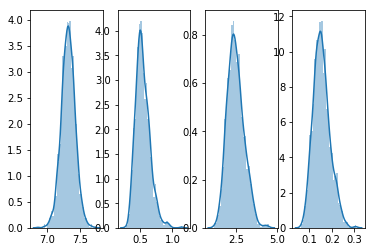

In [9]:
# graph all of the 
with twitter_model:
    imp_dists = ['alpha', 'sigma_squared_delta', 'a_tau', 'b_tau']
    fig, axs = plt.subplots(ncols=len(imp_dists))
    for i in range(len(imp_dists)):
        var = imp_dists[i]
        sns.distplot(trace[var], ax=axs[i]);
        print(var + ": " + str(np.mean(trace[var])) + "(" + str(np.std(trace[var])) + ")")
